<a href="https://colab.research.google.com/github/yasinsoylu1997/TEZZ2/blob/main/vgg19_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras
!pip install catboost

     |████████████████████████████████| 992 kB 5.3 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [5]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [6]:
X = []
y = []
image_size = 32
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:22<00:00, 59.74it/s] 


In [7]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,32,32,3)
oversampled_y

array(['Lung_Opacity', 'Lung_Opacity', 'Lung_Opacity', ...,
       'Viral Pneumonia', 'Viral Pneumonia', 'Viral Pneumonia'],
      dtype='<U15')

In [8]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

In [9]:
train_images=train_images[:1500]
test_images=test_images[:1500]
train_labels=train_labels[:1500]
test_labels=test_labels[:1500]

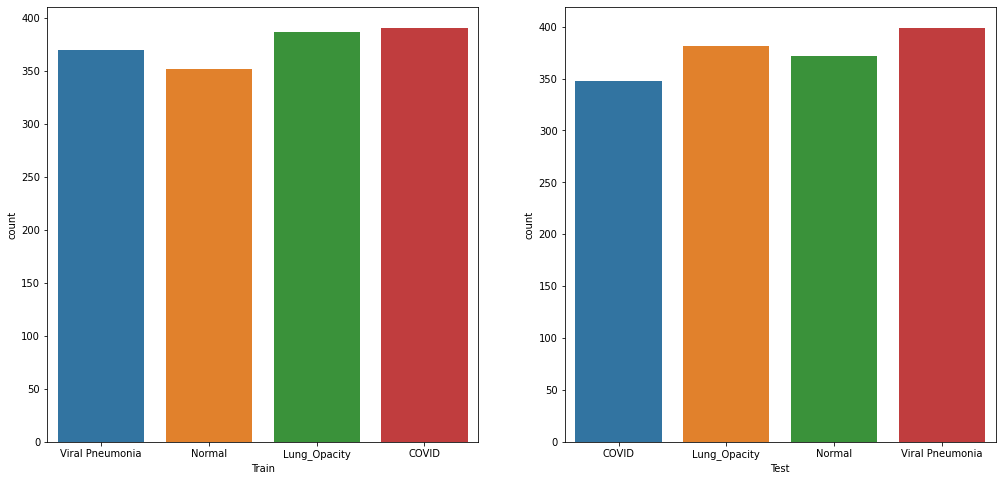

In [10]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [11]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [13]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [14]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [15]:
y_test_one_hot

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [16]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [17]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input to RF

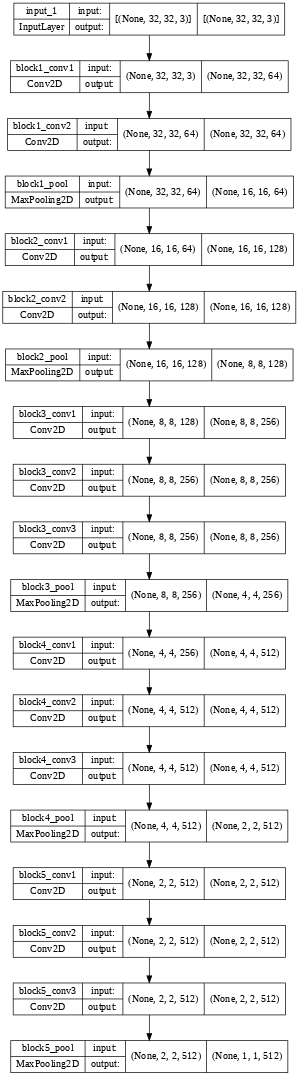

In [18]:
from keras.utils.vis_utils import plot_model

plot_model(VGG_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

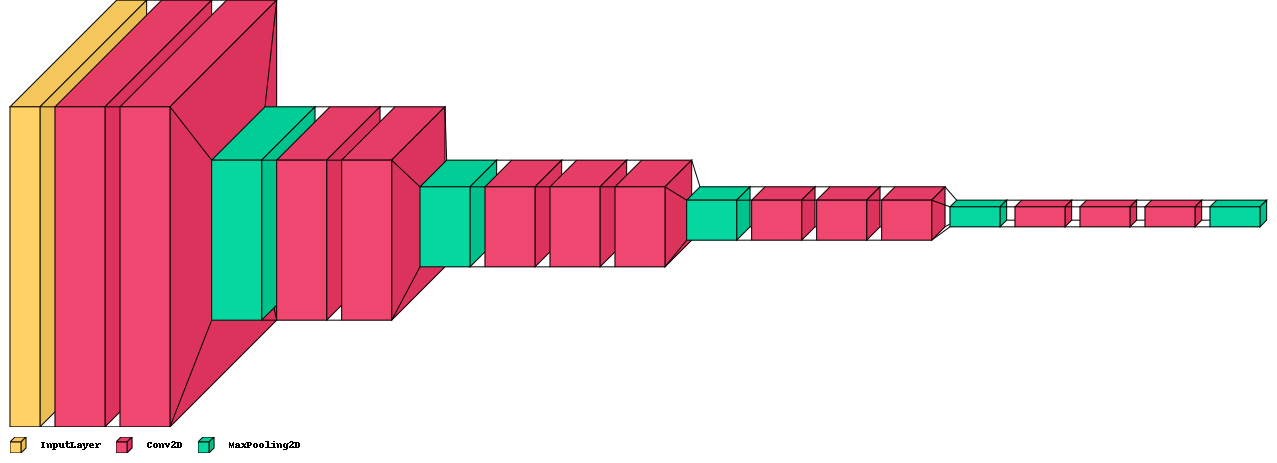

<Figure size 144x144 with 0 Axes>

In [19]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(VGG_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [20]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

# knn

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [22]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [23]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.4713333333333333
MSE: 0.7593333333333333
RMSE: 0.871397345264107
R2 Square 0.3894542289005246
Accuracy 0.6633333333333333
__________________________________


In [24]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.471333,0.759333,0.871397,0.389454,0.663333


In [25]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.55      0.60      0.58       348
           1       0.61      0.61      0.61       381
           2       0.56      0.55      0.56       372
           3       0.93      0.87      0.90       399

    accuracy                           0.66      1500
   macro avg       0.66      0.66      0.66      1500
weighted avg       0.67      0.66      0.67      1500



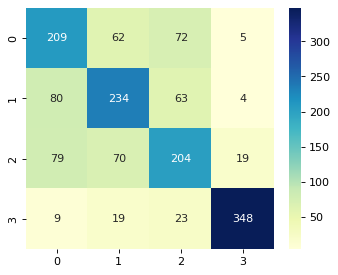

In [26]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [27]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [28]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [29]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.37666666666666665
MSE: 0.6126666666666667
RMSE: 0.7827302643099133
R2 Square 0.5073822970672363
Accuracy 0.734
__________________________________


In [30]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.471333,0.759333,0.871397,0.389454,0.663333
1,SVC,0.376667,0.612667,0.782730,0.507382,0.734000


In [31]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.59      0.64      0.62       348
           1       0.71      0.70      0.71       381
           2       0.68      0.64      0.66       372
           3       0.94      0.93      0.94       399

    accuracy                           0.73      1500
   macro avg       0.73      0.73      0.73      1500
weighted avg       0.74      0.73      0.73      1500



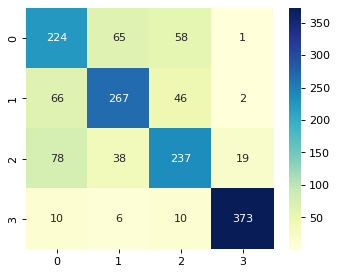

In [32]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RBF SVC

In [33]:
from sklearn.svm import SVC

svc_model = SVC(kernel = "rbf").fit(X_for_model, y_train)
svc_model = svc_model.fit(X_for_model, y_train)
svc_model

SVC()

In [34]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svc_model.predict(X_test_features)

In [35]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.43266666666666664
MSE: 0.7086666666666667
RMSE: 0.8418234177466595
R2 Square 0.4301930160853886
Accuracy 0.6946666666666667
__________________________________


In [36]:
results_df_2 = pd.DataFrame(data=[["RBF SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.471333,0.759333,0.871397,0.389454,0.663333
1,SVC,0.376667,0.612667,0.782730,0.507382,0.734000
2,RBF SVC,0.432667,0.708667,0.841823,0.430193,0.694667


In [37]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56       348
           1       0.67      0.70      0.68       381
           2       0.62      0.58      0.60       372
           3       0.90      0.92      0.91       399

    accuracy                           0.69      1500
   macro avg       0.69      0.69      0.69      1500
weighted avg       0.69      0.69      0.69      1500



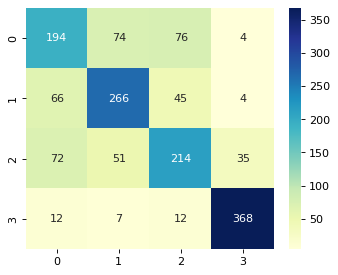

In [38]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [39]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [40]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [41]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.626
MSE: 1.0913333333333333
RMSE: 1.044669006591721
R2 Square 0.12250796550496812
Accuracy 0.5773333333333334
__________________________________


In [42]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.471333,0.759333,0.871397,0.389454,0.663333
1,SVC,0.376667,0.612667,0.782730,0.507382,0.734000
2,RBF SVC,0.432667,0.708667,0.841823,0.430193,0.694667
3,DecisionTreeClassifier,0.626000,1.091333,1.044669,0.122508,0.577333


In [43]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.45      0.50      0.48       348
           1       0.54      0.50      0.52       381
           2       0.49      0.47      0.48       372
           3       0.80      0.82      0.81       399

    accuracy                           0.58      1500
   macro avg       0.57      0.57      0.57      1500
weighted avg       0.58      0.58      0.58      1500



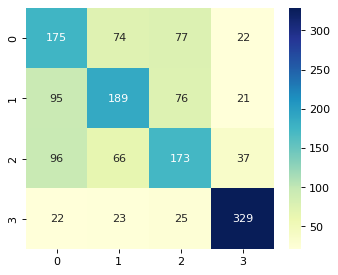

In [44]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [45]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [46]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [47]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.4013333333333333
MSE: 0.6466666666666666
RMSE: 0.8041558721209878
R2 Square 0.48004442671949854
Accuracy 0.7153333333333334
__________________________________


In [48]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.471333,0.759333,0.871397,0.389454,0.663333
1,SVC,0.376667,0.612667,0.782730,0.507382,0.734000
2,RBF SVC,0.432667,0.708667,0.841823,0.430193,0.694667
3,DecisionTreeClassifier,0.626000,1.091333,1.044669,0.122508,0.577333
4,LogisticRegression,0.401333,0.646667,0.804156,0.480044,0.715333


In [49]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.61      0.59      0.60       348
           1       0.68      0.70      0.69       381
           2       0.63      0.61      0.62       372
           3       0.91      0.93      0.92       399

    accuracy                           0.72      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.71      0.72      0.71      1500



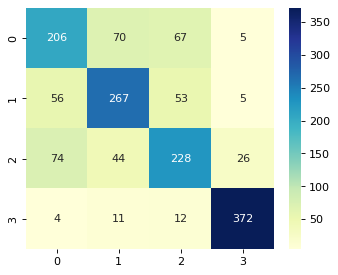

In [50]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [51]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [52]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [53]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.424
MSE: 0.604
RMSE: 0.7771743691090179
R2 Square 0.5143507738225419
Accuracy 0.6593333333333333
__________________________________


In [54]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.471333,0.759333,0.871397,0.389454,0.663333
1,SVC,0.376667,0.612667,0.782730,0.507382,0.734000
2,RBF SVC,0.432667,0.708667,0.841823,0.430193,0.694667
3,DecisionTreeClassifier,0.626000,1.091333,1.044669,0.122508,0.577333
4,LogisticRegression,0.401333,0.646667,0.804156,0.480044,0.715333
5,SGDClassifier,0.424000,0.604000,0.777174,0.514351,0.659333


In [55]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.63      0.41      0.49       348
           1       0.49      0.91      0.64       381
           2       0.78      0.34      0.47       372
           3       0.91      0.94      0.92       399

    accuracy                           0.66      1500
   macro avg       0.70      0.65      0.63      1500
weighted avg       0.71      0.66      0.64      1500



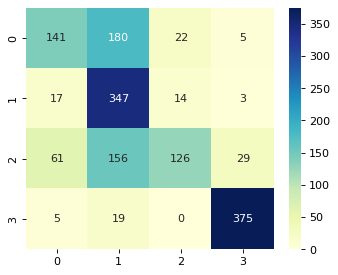

In [56]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GradientBoostingClassifier

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

GBC_model = GradientBoostingClassifier()
GBC_model = GBC_model.fit(X_for_model, y_train)
GBC_model

GradientBoostingClassifier()

In [58]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GBC_model.predict(X_test_features)

In [59]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.406
MSE: 0.6633333333333333
RMSE: 0.8144527815247078
R2 Square 0.46664350988237224
Accuracy 0.7133333333333334
__________________________________


In [60]:
results_df_2 = pd.DataFrame(data=[["GradientBoostingClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.471333,0.759333,0.871397,0.389454,0.663333
1,SVC,0.376667,0.612667,0.782730,0.507382,0.734000
2,RBF SVC,0.432667,0.708667,0.841823,0.430193,0.694667
3,DecisionTreeClassifier,0.626000,1.091333,1.044669,0.122508,0.577333
4,LogisticRegression,0.401333,0.646667,0.804156,0.480044,0.715333
5,SGDClassifier,0.424000,0.604000,0.777174,0.514351,0.659333
6,GradientBoostingClassifier,0.406000,0.663333,0.814453,0.466644,0.713333


In [61]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.59      0.65      0.61       348
           1       0.68      0.68      0.68       381
           2       0.64      0.58      0.61       372
           3       0.92      0.92      0.92       399

    accuracy                           0.71      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.71      0.71      0.71      1500



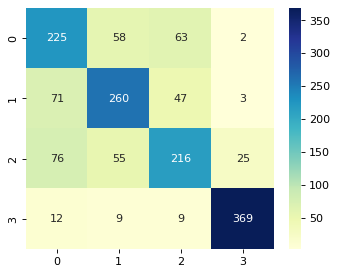

In [62]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [63]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [64]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [65]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.392
MSE: 0.664
RMSE: 0.8148619514985346
R2 Square 0.4661074732088871
Accuracy 0.7306666666666667
__________________________________


In [66]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.471333,0.759333,0.871397,0.389454,0.663333
1,SVC,0.376667,0.612667,0.782730,0.507382,0.734000
2,RBF SVC,0.432667,0.708667,0.841823,0.430193,0.694667
3,DecisionTreeClassifier,0.626000,1.091333,1.044669,0.122508,0.577333
4,LogisticRegression,0.401333,0.646667,0.804156,0.480044,0.715333
5,SGDClassifier,0.424000,0.604000,0.777174,0.514351,0.659333
6,GradientBoostingClassifier,0.406000,0.663333,0.814453,0.466644,0.713333
7,LGBMClassifier,0.392000,0.664000,0.814862,0.466107,0.730667


In [67]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.60      0.64      0.62       348
           1       0.71      0.69      0.70       381
           2       0.67      0.63      0.65       372
           3       0.92      0.94      0.93       399

    accuracy                           0.73      1500
   macro avg       0.73      0.73      0.73      1500
weighted avg       0.73      0.73      0.73      1500



# XGBClassifier

In [68]:
from xgboost.sklearn import XGBClassifier

XGBC_model = XGBClassifier()
XGBC_model = XGBC_model.fit(X_for_model, y_train)
XGBC_model

XGBClassifier(objective='multi:softprob')

In [69]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = XGBC_model.predict(X_test_features)

In [70]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.4033333333333333
MSE: 0.6646666666666666
RMSE: 0.815270916117254
R2 Square 0.4655714365354021
Accuracy 0.7186666666666667
__________________________________


In [71]:
results_df_2 = pd.DataFrame(data=[["XGBClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.471333,0.759333,0.871397,0.389454,0.663333
1,SVC,0.376667,0.612667,0.782730,0.507382,0.734000
2,RBF SVC,0.432667,0.708667,0.841823,0.430193,0.694667
3,DecisionTreeClassifier,0.626000,1.091333,1.044669,0.122508,0.577333
4,LogisticRegression,0.401333,0.646667,0.804156,0.480044,0.715333
5,SGDClassifier,0.424000,0.604000,0.777174,0.514351,0.659333
6,GradientBoostingClassifier,0.406000,0.663333,0.814453,0.466644,0.713333
7,LGBMClassifier,0.392000,0.664000,0.814862,0.466107,0.730667
8,XGBClassifier,0.403333,0.664667,0.815271,0.465571,0.718667


In [72]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59       348
           1       0.69      0.70      0.69       381
           2       0.64      0.62      0.63       372
           3       0.92      0.95      0.93       399

    accuracy                           0.72      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.72      0.72      0.72      1500



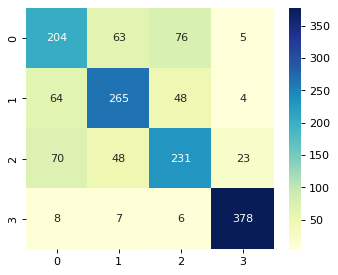

In [73]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [74]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [75]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [76]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3893333333333333
MSE: 0.6266666666666667
RMSE: 0.7916228058025279
R2 Square 0.4961255269240501
Accuracy 0.722
__________________________________


In [77]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.471333,0.759333,0.871397,0.389454,0.663333
1,SVC,0.376667,0.612667,0.782730,0.507382,0.734000
2,RBF SVC,0.432667,0.708667,0.841823,0.430193,0.694667
3,DecisionTreeClassifier,0.626000,1.091333,1.044669,0.122508,0.577333
4,LogisticRegression,0.401333,0.646667,0.804156,0.480044,0.715333
5,SGDClassifier,0.424000,0.604000,0.777174,0.514351,0.659333
6,GradientBoostingClassifier,0.406000,0.663333,0.814453,0.466644,0.713333
7,LGBMClassifier,0.392000,0.664000,0.814862,0.466107,0.730667
8,XGBClassifier,0.403333,0.664667,0.815271,0.465571,0.718667
9,RandomForestClassifier,0.389333,0.626667,0.791623,0.496126,0.722000


In [78]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62       348
           1       0.67      0.72      0.69       381
           2       0.67      0.57      0.62       372
           3       0.90      0.95      0.93       399

    accuracy                           0.72      1500
   macro avg       0.71      0.72      0.71      1500
weighted avg       0.72      0.72      0.72      1500



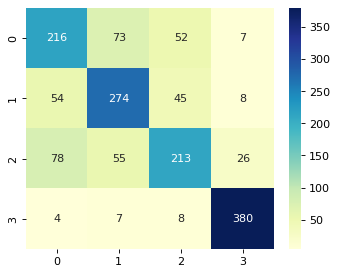

In [79]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [80]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [81]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [82]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.6566666666666666
MSE: 1.0633333333333332
RMSE: 1.0311805532172014
R2 Square 0.14502150579134032
Accuracy 0.5313333333333333
__________________________________


In [83]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.471333,0.759333,0.871397,0.389454,0.663333
1,SVC,0.376667,0.612667,0.782730,0.507382,0.734000
2,RBF SVC,0.432667,0.708667,0.841823,0.430193,0.694667
3,DecisionTreeClassifier,0.626000,1.091333,1.044669,0.122508,0.577333
4,LogisticRegression,0.401333,0.646667,0.804156,0.480044,0.715333
5,SGDClassifier,0.424000,0.604000,0.777174,0.514351,0.659333
6,GradientBoostingClassifier,0.406000,0.663333,0.814453,0.466644,0.713333
7,LGBMClassifier,0.392000,0.664000,0.814862,0.466107,0.730667
8,XGBClassifier,0.403333,0.664667,0.815271,0.465571,0.718667
9,RandomForestClassifier,0.389333,0.626667,0.791623,0.496126,0.722000


In [84]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.61      0.16      0.25       348
           1       0.58      0.39      0.47       381
           2       0.39      0.87      0.53       372
           3       0.86      0.67      0.76       399

    accuracy                           0.53      1500
   macro avg       0.61      0.52      0.50      1500
weighted avg       0.61      0.53      0.51      1500



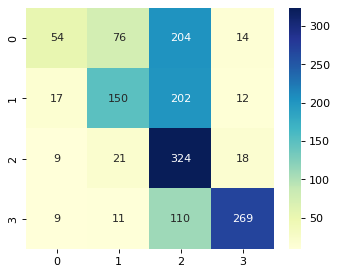

In [85]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [86]:
modeller = [rf_model,GB_model,XGBC_model,LGBM_model,GBC_model,SGD_model,lr_model,cart_model,svc_model,svm_model,knn_model]

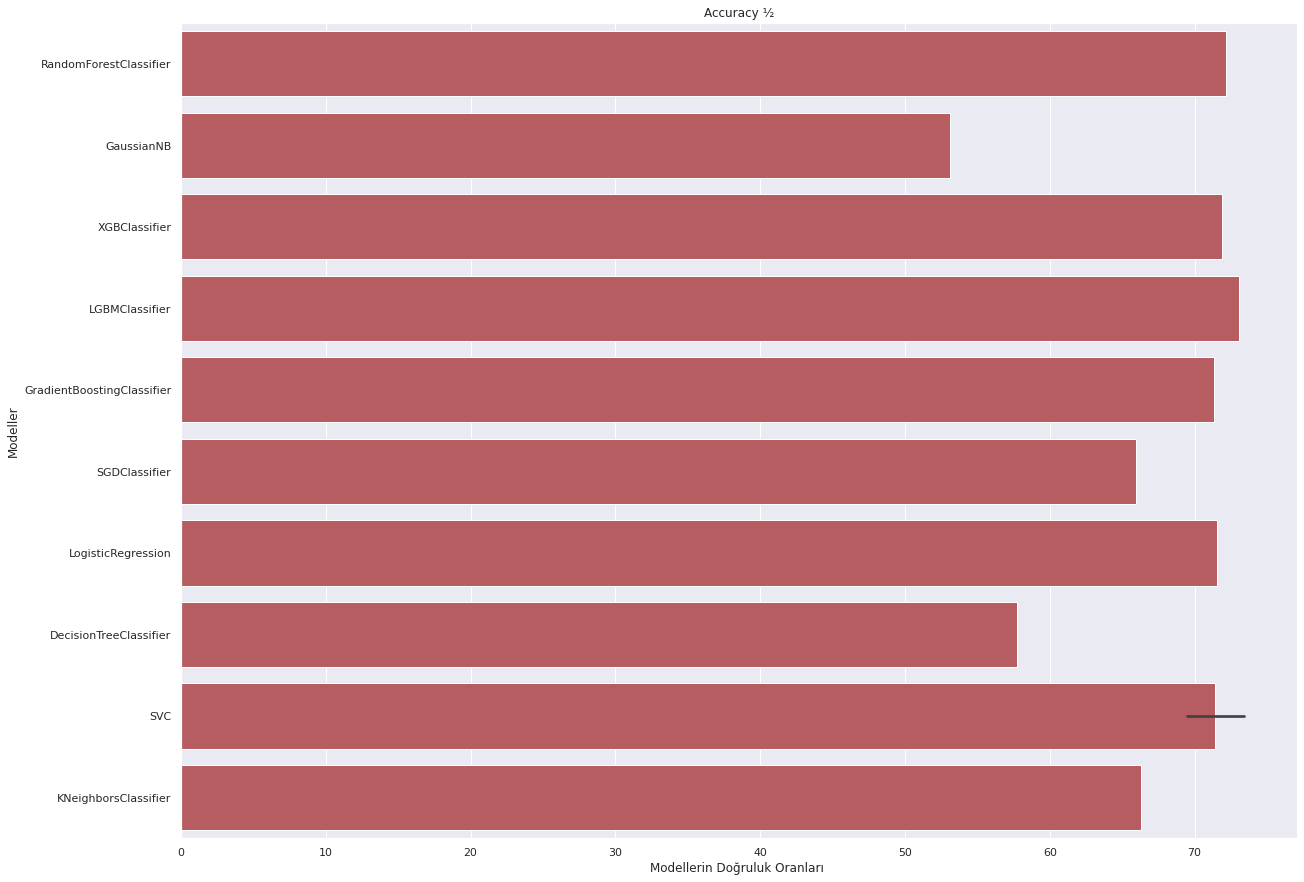

In [89]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy"])
    sonuclar = sonuclar.append(sonuc)
    
sns.set(rc={'figure.figsize':(20,15)})
sns.barplot(x= 'Accuracy', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('Modellerin Doğruluk Oranları ')
plt.title('Accuracy ½'); 

In [90]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy
0,KNeighborsClassifier,0.471333,0.759333,0.871397,0.389454,0.663333
1,SVC,0.376667,0.612667,0.782730,0.507382,0.734000
2,RBF SVC,0.432667,0.708667,0.841823,0.430193,0.694667
3,DecisionTreeClassifier,0.626000,1.091333,1.044669,0.122508,0.577333
4,LogisticRegression,0.401333,0.646667,0.804156,0.480044,0.715333
5,SGDClassifier,0.424000,0.604000,0.777174,0.514351,0.659333
6,GradientBoostingClassifier,0.406000,0.663333,0.814453,0.466644,0.713333
7,LGBMClassifier,0.392000,0.664000,0.814862,0.466107,0.730667
8,XGBClassifier,0.403333,0.664667,0.815271,0.465571,0.718667
9,RandomForestClassifier,0.389333,0.626667,0.791623,0.496126,0.722000


In [91]:
from google.colab import files

results_df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>